# Debugging/Testing PatternFinder

In [1]:
# Plot in this IPython Notebook instead of opening separate windows
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import scipy as sp
from skimage import io

In [2]:
import pattern_finder_gpu
from pattern_finder_gpu import center_roi_around, rotation_around

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [4]:
from matplotlib import pyplot as plt

In [5]:
from skimage import transform

In [6]:
import logging
logging.basicConfig()

We create a test image where we place a cross at a certain position. We later on want to find the position.

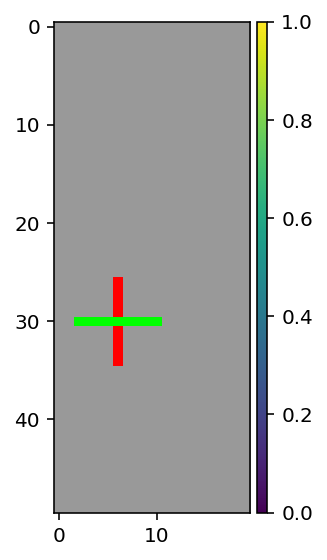

In [119]:
test_image = sp.ones((50,20,3), dtype=sp.float32) -0.4
test_cross_rc = [30, 6]

test_image[test_cross_rc[0]-4:test_cross_rc[0]+5, test_cross_rc[1]] = (1.0, 0, 0)
test_image[test_cross_rc[0], test_cross_rc[1]-4:test_cross_rc[1]+5] = (0, 1.0, 0)
io.imshow(test_image)

We define a target pattern that we use to find the cross in the test image. The target pattern is in the center.

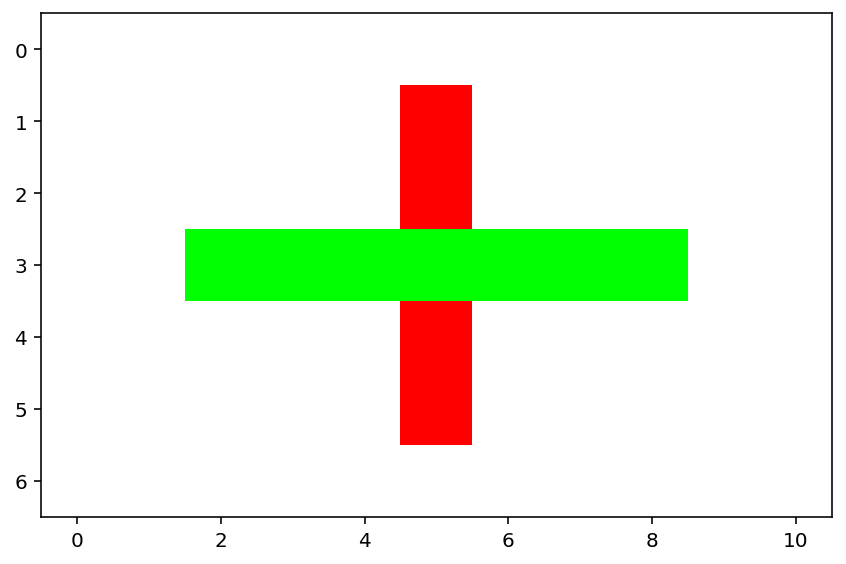

In [121]:
test_target = sp.ones((7,11,4), dtype=sp.float32)
test_target_center_rc = sp.array(test_target.shape[:2]) / 2 - 0.5

# boder transparent
test_target_cross_rc = sp.around(test_target_center_rc).astype(sp.int32)
test_target[test_target_cross_rc[0]-3:test_target_cross_rc[0]+4, test_target_cross_rc[1], :] = (1.0, 0, 0, 1)
test_target[test_target_cross_rc[0], test_target_cross_rc[1]-3:test_target_cross_rc[1]+4, :] = (0, 1.0, 0, 1)
#test_target = transform.warp(test_target, rotation_around(10, test_target_cross_rc))
test_target[0,:,3] = 0
test_target[-1,:,3] = 0
test_target[:,0,3] = 0
test_target[:,-1,3] = 0
io.imshow(test_target)

In [122]:
test_target[...,-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [123]:
test_roi = center_roi_around( (25,10), (21,11))


In [124]:
test_roi

(15, 5, 36, 16)

In [125]:
test_PF = pattern_finder_gpu.PatternFinder(partitions=1)

INFO:PatternFinder:<pyopencl.Context at 0x7feb499ef140 on <pyopencl.Device 'AMD Radeon Pro 560 Compute Engine' on 'Apple' at 0x7feb499e85b0>>


DEBUG:PatternFinder:Execution PatternFinder.find took 0.000004 ms


19.359999
[30  6]


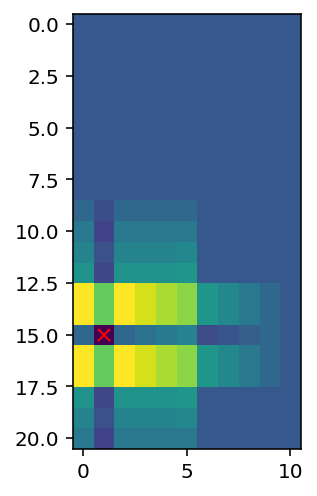

In [126]:
test_PF.set_image(test_image)
test_PF.set_pattern(test_target)
test_out, test_rc, test_val = test_PF.find(roi=test_roi)
print(test_val)
print(test_rc)
fig, ax = plt.subplots()
ax.imshow(test_out)
ax.plot(*(test_rc-test_roi[:2])[::-1], "rx")

In [127]:
test_out, test_rc, test_val1 = test_PF.find()
print(test_val1)

DEBUG:PatternFinder:Execution PatternFinder.find took 0.000001 ms


19.359999


In [128]:
test_out, test_rc, test_val2 = test_PF.find(test_target, test_image)
print(test_val2)

DEBUG:PatternFinder:Execution PatternFinder.find took 0.000002 ms


19.359999


In [129]:
assert(test_val1 == test_val2)

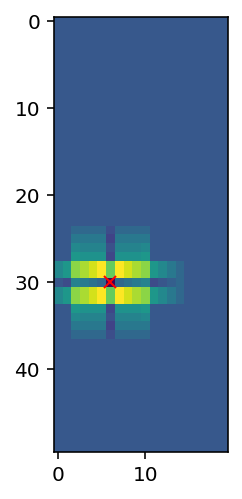

In [130]:
fig, ax = plt.subplots()
ax.imshow(test_out)
ax.plot(*test_rc[::-1], "rx")

In [131]:
test_rc

array([30,  6])

In [132]:
test_cross_rc

[30, 6]

In [133]:
assert sp.allclose(test_rc, test_cross_rc)

In [187]:
true_rot = 4 #deg
true_trans = -sp.array([10,5])
true_transe = (
    rotation_around(true_rot, around_rc=sp.asarray(test_cross_rc)) +
    transform.AffineTransform(translation=true_trans[::-1])
)

In [188]:
true_transe.params

array([[  0.99756405,  -0.06975647,  -2.89269009],
       [  0.06975647,   0.99756405, -10.34546035],
       [  0.        ,   0.        ,   1.        ]])

In [189]:
test_image_transfromed = transform.warp(test_image,
                                        true_transe,
                                       )#output_shape=[test_target.shape[0], test_target.shape[1]])

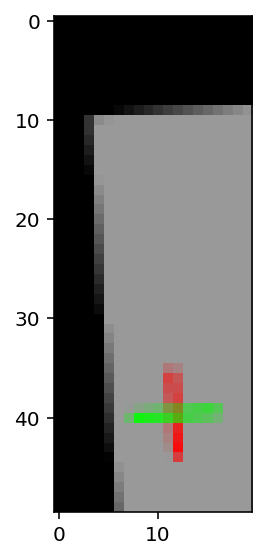

In [190]:
io.imshow(test_image_transfromed)

## find_pattern_rotated example

In [191]:
test_image_transfromed.shape

(50, 20, 3)

In [192]:
def propeller(deg, dx, dy):
    T = (
        transform.AffineTransform(translation=(-dx, -dy)) +
        rotation_around(deg, around_rc=test_rc)
    )
    io.imshow(transform.warp(test_image, T))
interact(propeller, deg=(-100,100,1), dx=(-10,10,1), dy=(-10,10,1))

interactive(children=(IntSlider(value=0, description='deg', min=-100), IntSlider(value=0, description='dx', ma…

<function __main__.propeller(deg, dx, dy)>

INFO:find_pattern_rotated:Rescaling image and target by scale=1.0.
    image (row, columns): (50, 20) px --> [50. 20.] px.
INFO:find_pattern_rotated:ROI center_rc=[26  9], in unscaled image.
     (height, width) = (37, 17) in scaled image.
INFO:find_pattern_rotated:Trying rotations: [-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.].
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000002 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000002 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000002 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000002 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000002 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000012 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000010 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000005 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000001 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000004 ms
D

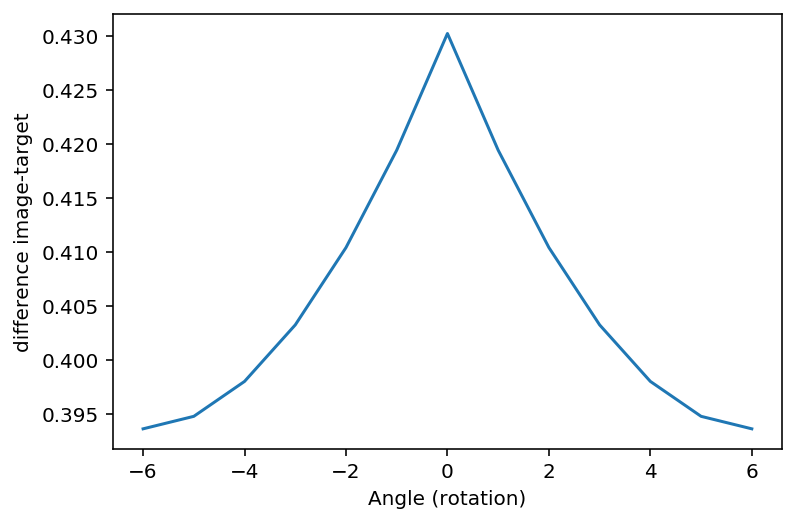

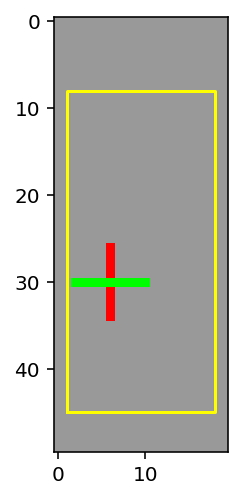

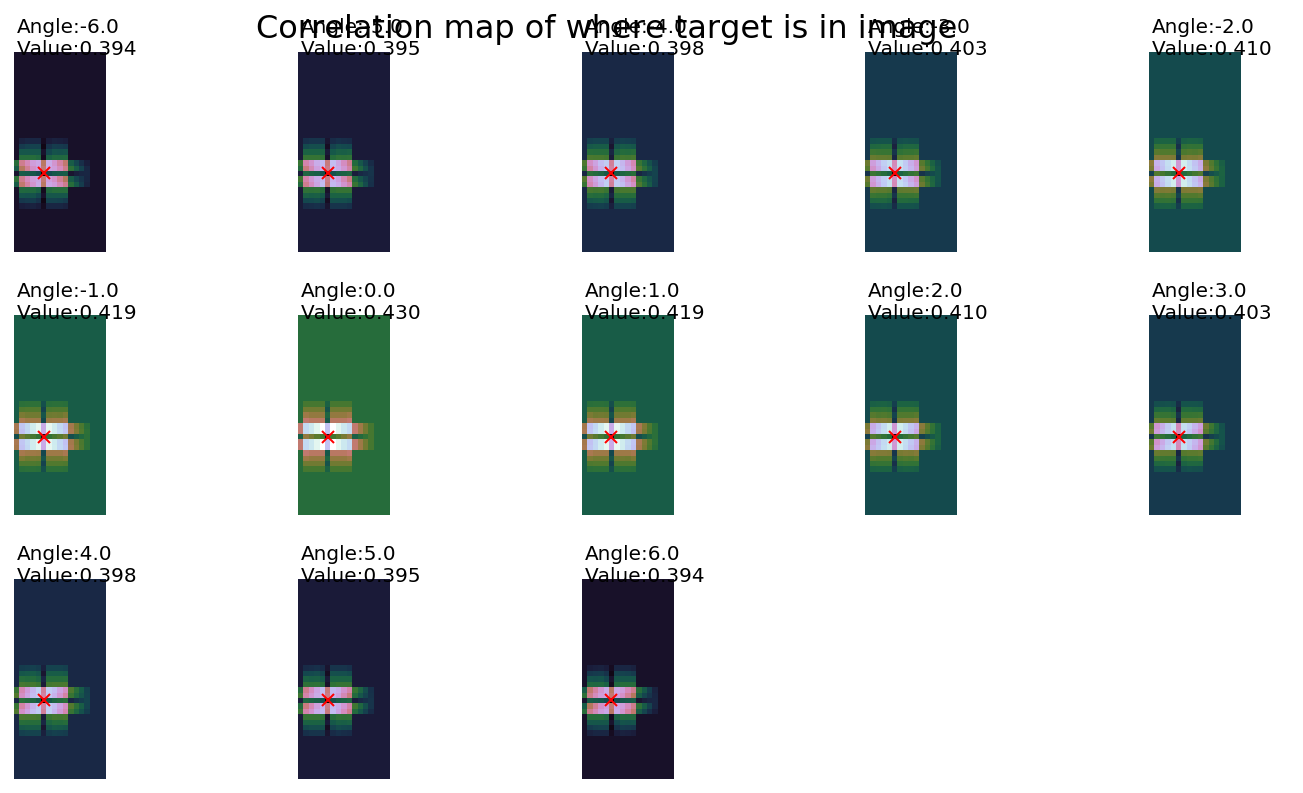

In [193]:
found_trans, found_value = pattern_finder_gpu.find_pattern_rotated(test_PF,
                                                                   test_target,
                                                                   test_image,
                                                                   rotations=sp.linspace(-6,6,13),
                                                                   roi_size_hw=(37,17),
                                                                   roi_center_rc=(26,9),
                                                                   plot='all')

In [194]:
found_trans.params

array([[ 0.9945219 , -0.10452846,  1.34097591],
       [ 0.10452846,  0.9945219 , 26.493792  ],
       [ 0.        ,  0.        ,  1.        ]])

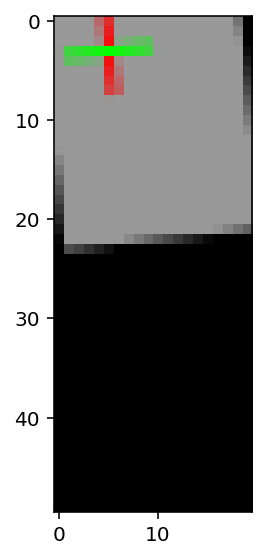

In [195]:
io.imshow(transform.warp(test_image, found_trans))

## Test Rotation and Translation

Let's use a nice image from the data that comes with skimage and show it

In [196]:
from skimage import data

In [197]:
test_image2 = data.coffee()

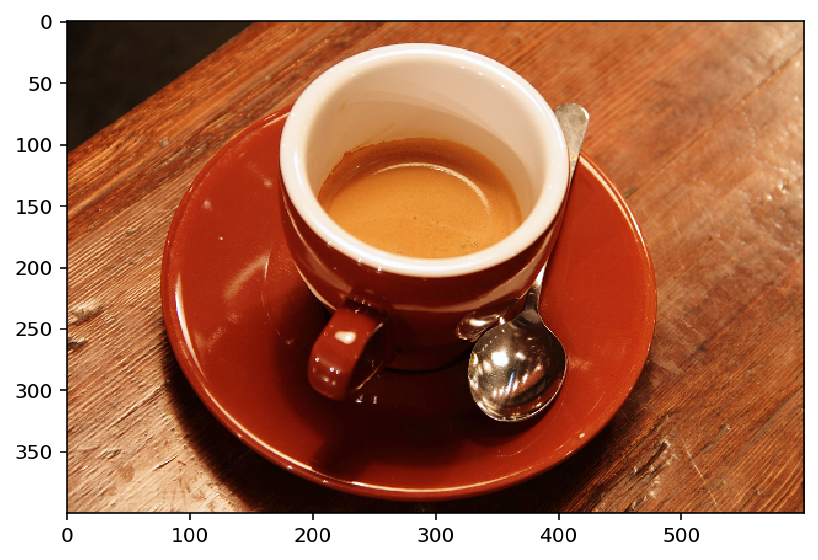

In [198]:
io.imshow(test_image2)

Use a cutout of the `test_image2` as the target and make it RGBA (as uint8)

In [199]:
test_image2.shape

(400, 600, 3)

In [200]:
test_image2.dtype

dtype('uint8')

In [201]:
test_target2 = sp.ones((101, 201, 4), dtype='uint8') * 255
test_target2[:,:,:3] = test_image2[150:251,150:351,:]
test_target2.shape

(101, 201, 4)

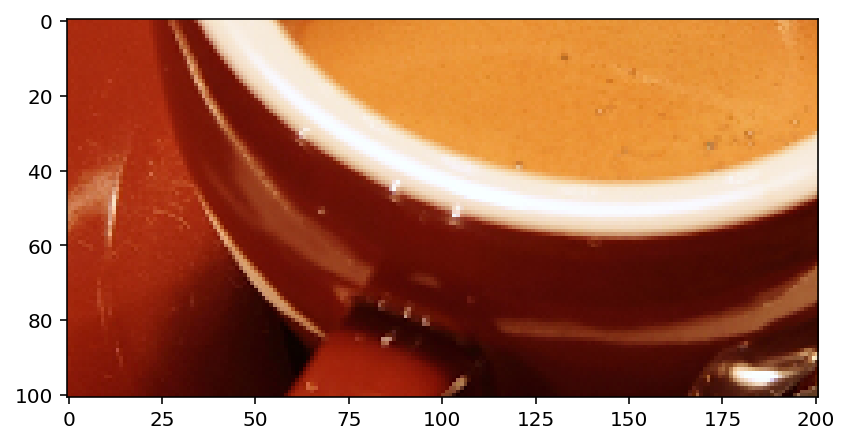

In [202]:
io.imshow(test_target2)

In [203]:
test_image2.shape

(400, 600, 3)

In [204]:
theta = 20
dxy = sp.array((-50,-100))
test_image2_transform = transform.AffineTransform(rotation=sp.deg2rad(theta), translation=dxy)

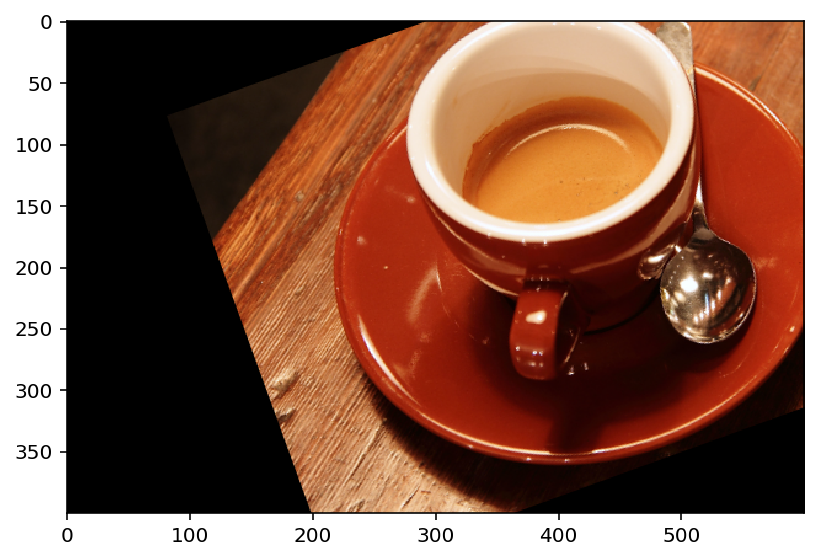

In [205]:
test_image2_rotated_translated = transform.warp(test_image2, test_image2_transform)
io.imshow(test_image2_rotated_translated)

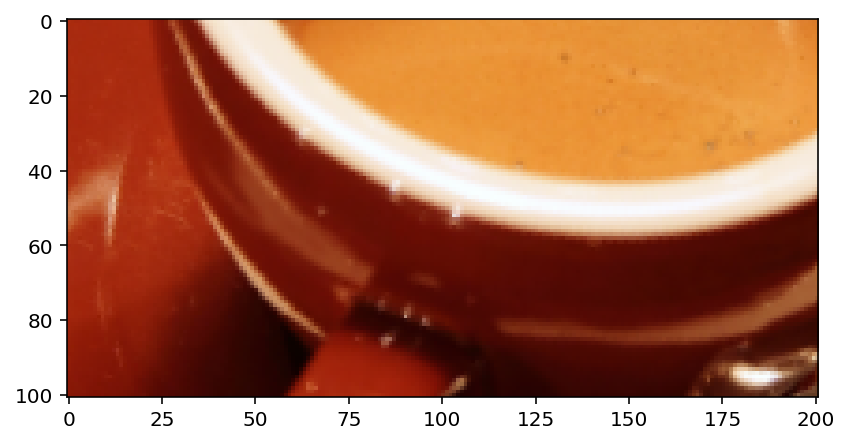

In [206]:
true_reverse_transform = (transform.AffineTransform(translation=-dxy+(150,150)) +
                         transform.AffineTransform(rotation=-sp.deg2rad(theta)))
true_reversed_test_image2 = transform.warp(test_image2_rotated_translated,
                                           true_reverse_transform, 
                                           output_shape=test_target2.shape)
io.imshow(true_reversed_test_image2)

We can see it fits perfectly. Now let's try if find_pattern_rotate can reach a similar result:

INFO:find_pattern_rotated:Rescaling image and target by scale=1.
    image (row, columns): (400, 600) px --> [400 600] px.
INFO:find_pattern_rotated:ROI center_rc=[253 300], in unscaled image.
     (height, width) = (191, 307) in scaled image.
INFO:find_pattern_rotated:Trying rotations: [-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37.
 -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23.
 -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.].
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000135 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000134 ms
DEBUG:PatternFinder:Execution PatternFinder.find took 0.000123 ms

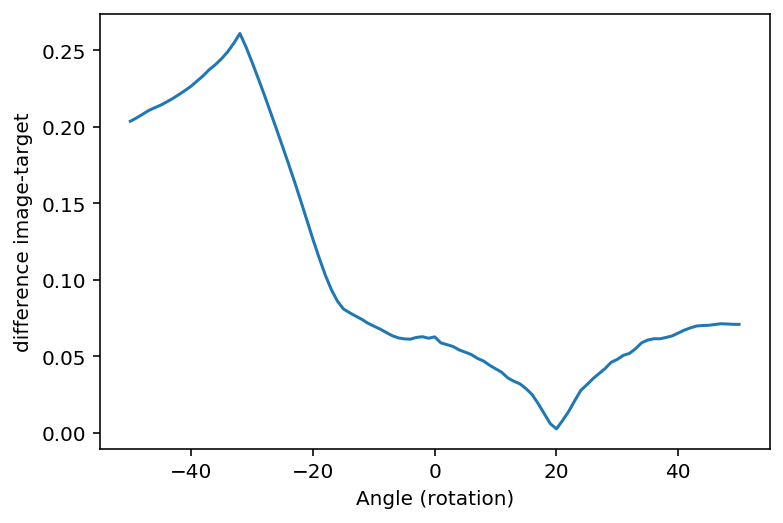

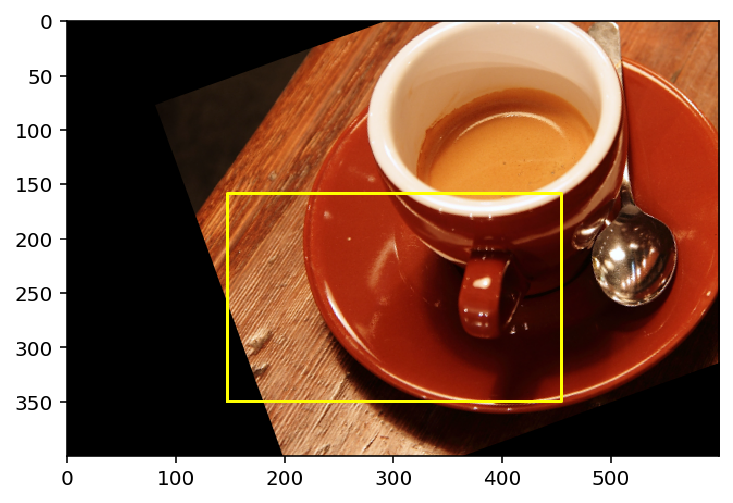

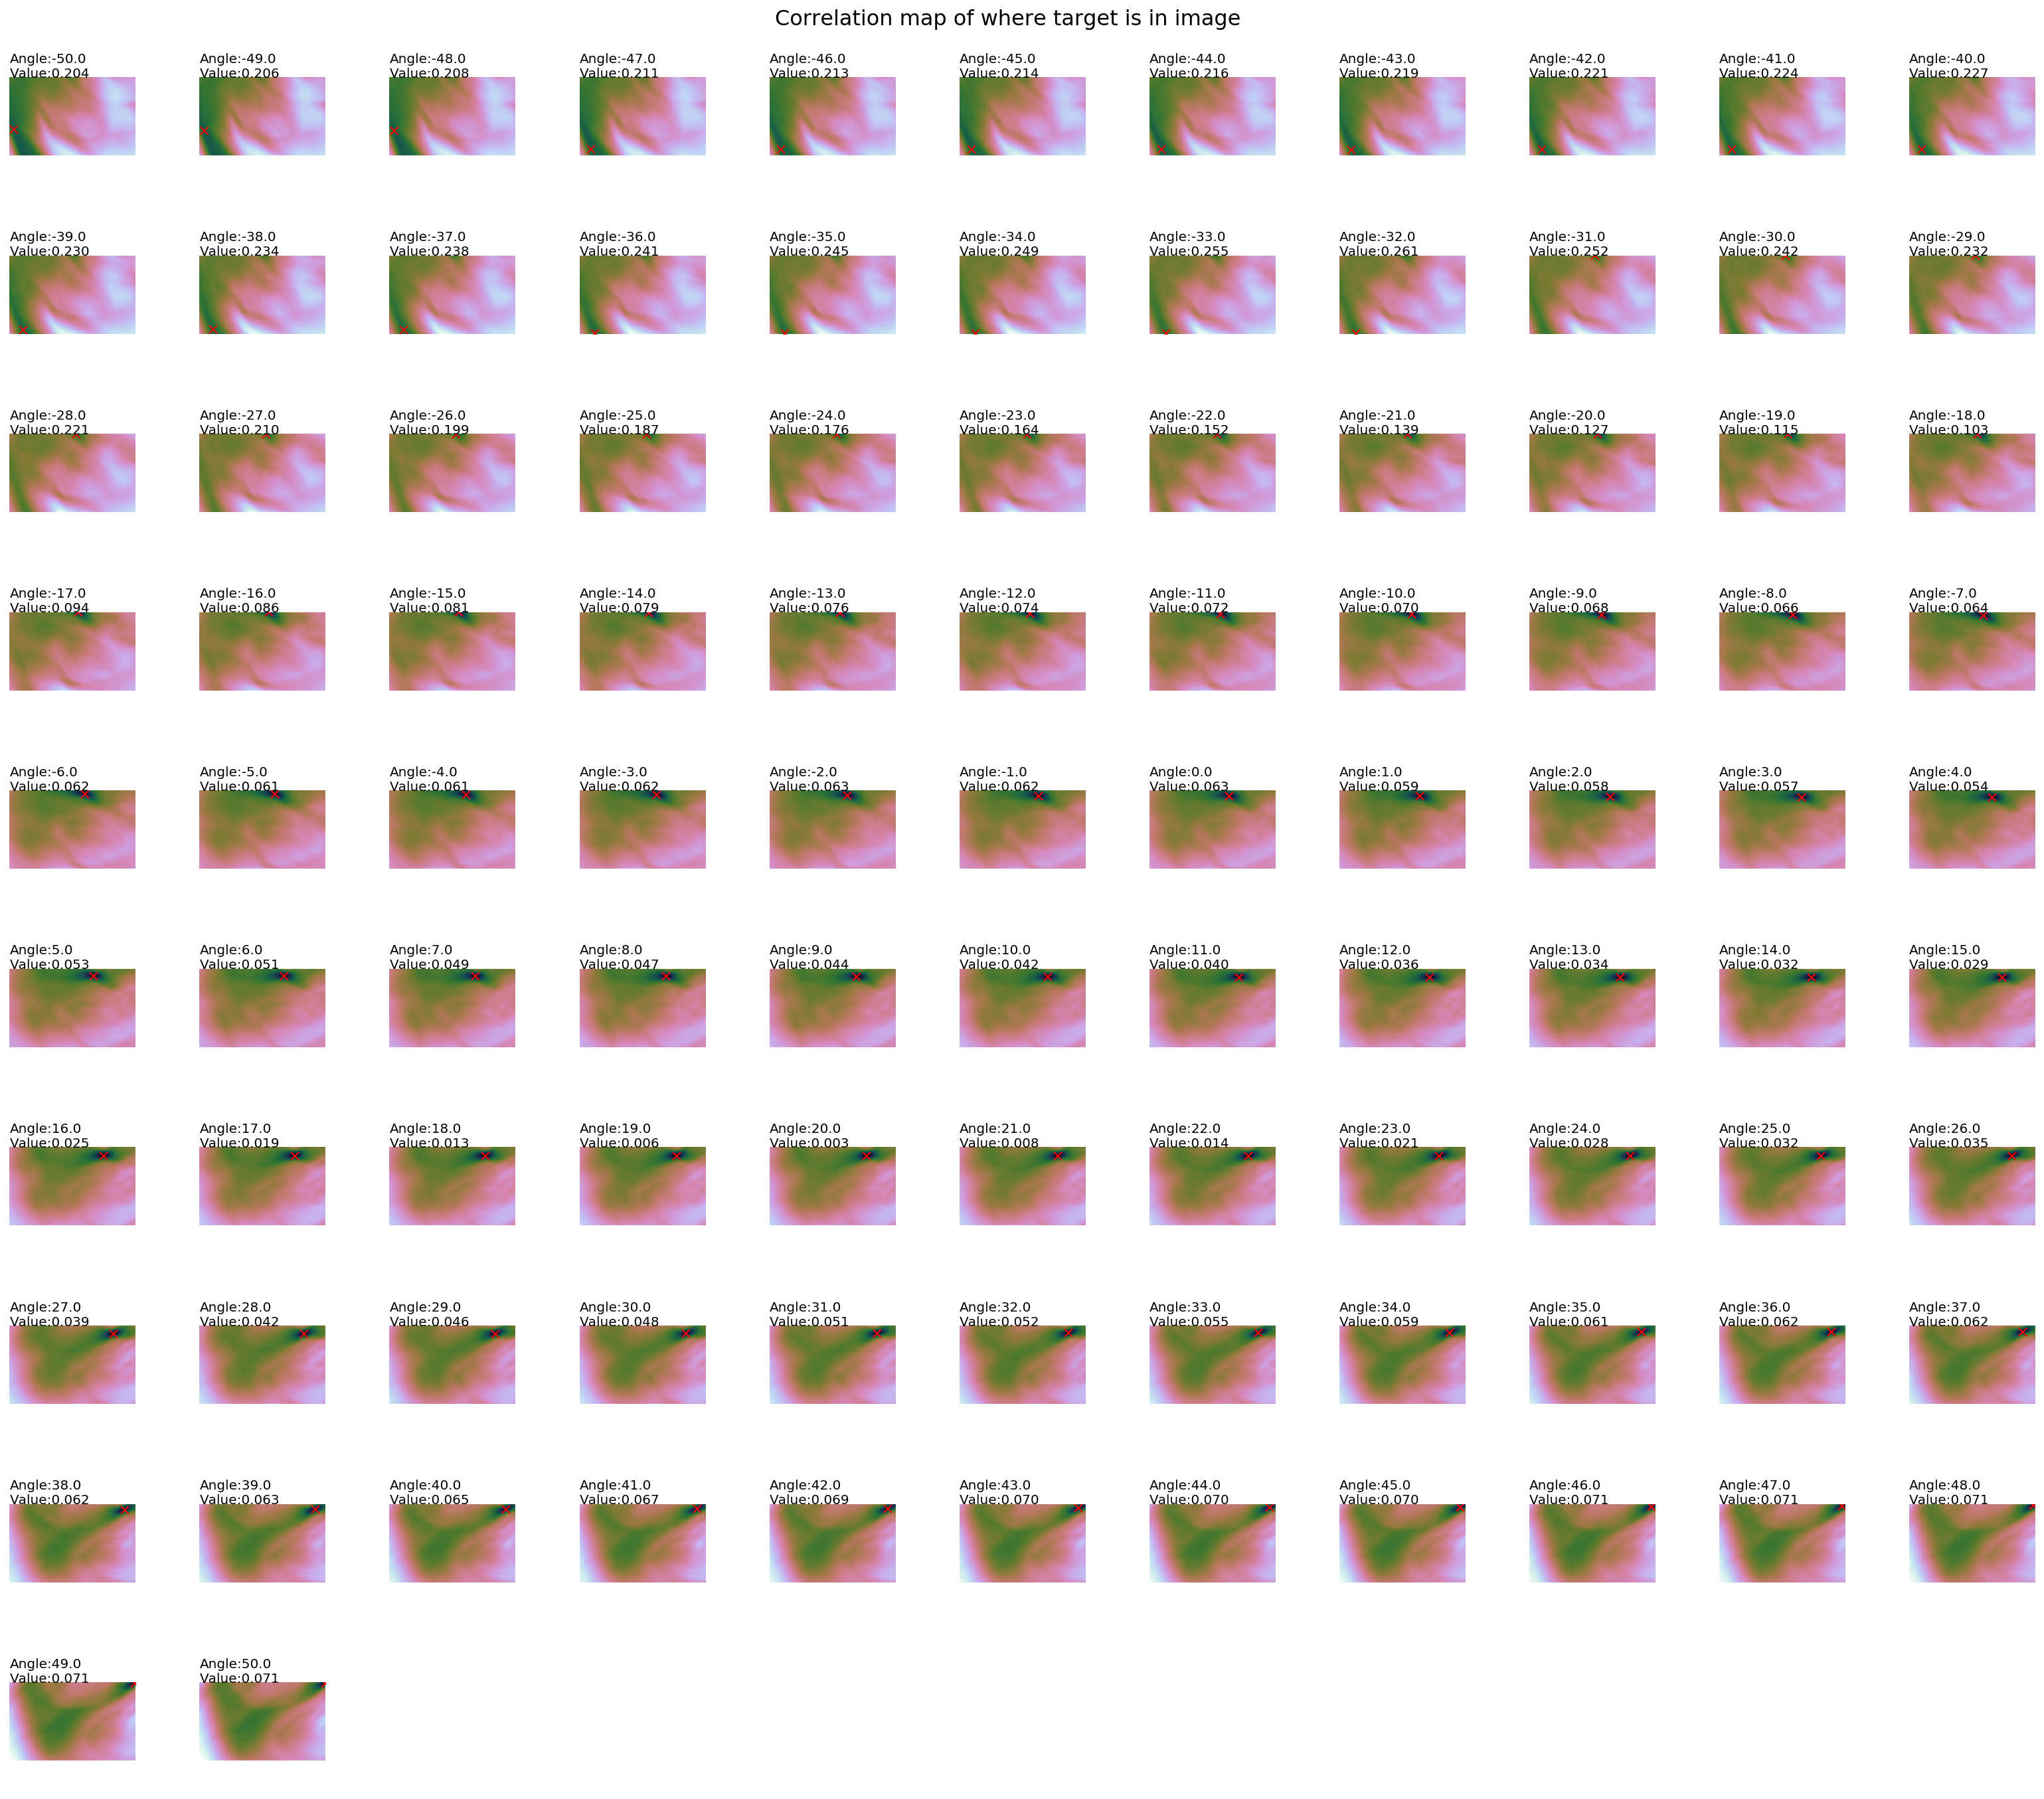

In [207]:
trans, value = pattern_finder_gpu.find_pattern_rotated(test_PF,
                                                       test_target2,
                                                       test_image2_rotated_translated,
                                                       rescale=1,
                                                       rotations=sp.linspace(-50, 50 , 50+50+1),
                                                       roi_size_hw=(191, 307),
                                                       roi_center_rc=(253, 300), # row, col
                                                       plot='all')

In [208]:
center_roi_around((330, 220), (221,221))

(220, 110, 441, 331)

In [209]:
sp.rad2deg(trans.rotation)

-20.0

In [211]:
trans.translation

array([272.92973076, 166.21738329])

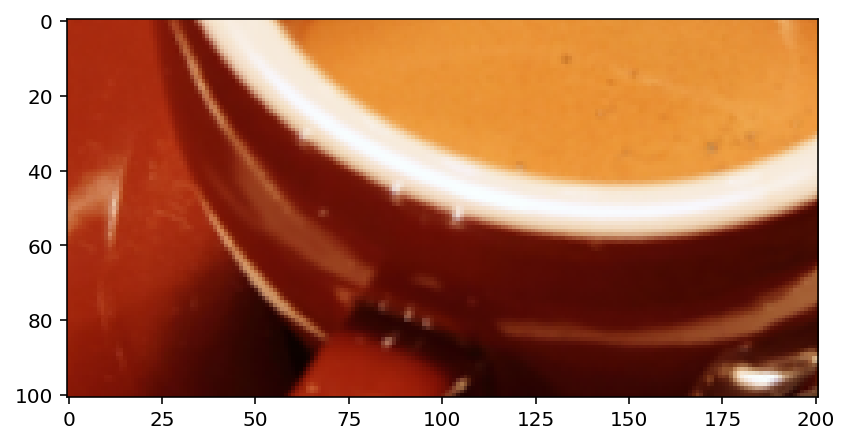

In [212]:
result = transform.warp(test_image2_rotated_translated, trans, output_shape=test_target2.shape)
io.imshow(result)

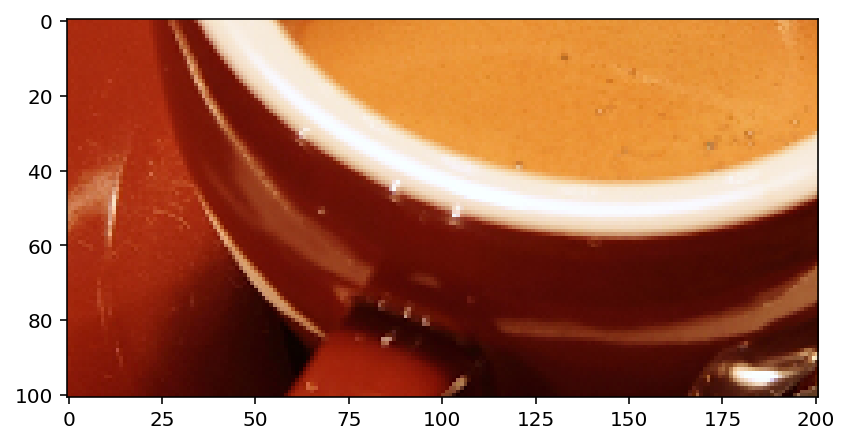

In [213]:
io.imshow(test_target2)

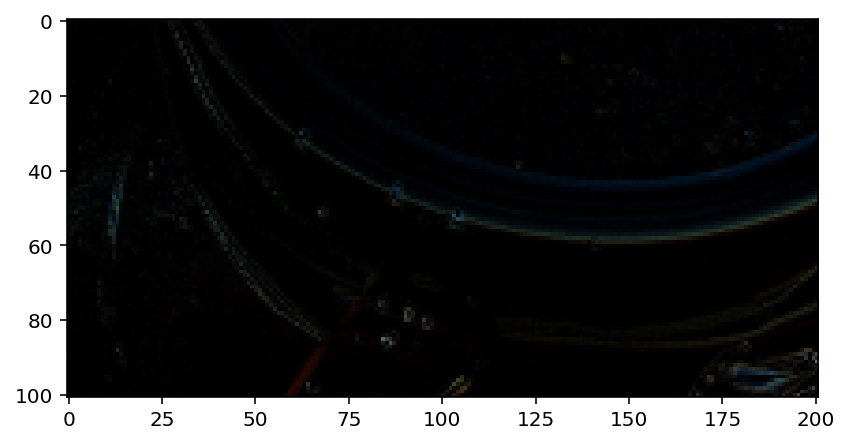

In [214]:
io.imshow(sp.absolute(test_target2[...,:3]/255 - result))